# Задание 5. U-net
Использую архитектуру U-net, разработать модель сегментации на основе нейронной сети.

# Импорт библиотек

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

#Библиотека для лосс функции
!pip install segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


# Параметры

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 15
BUFFER_SIZE = 1000
VAL_SPLIT = 0.2

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Загрузка датасета

In [ ]:
(ds_full,), ds_info = tfds.load(
'oxford_iiit_pet',
split=['train'],
with_info=True,
as_supervised=False,
)


# Разделяем train на train/val
n_total = ds_info.splits['train'].num_examples
n_train = int(n_total * (1 - VAL_SPLIT))


ds_train = ds_full.take(n_train)
ds_val = ds_full.skip(n_train)

print(len(ds_train))
print(len(ds_val))

ds_test = tfds.load('oxford_iiit_pet', split='test', as_supervised=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.4XLIT2_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.4XLIT2_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
2944
736


# Препроцессинг

In [ ]:
def preprocess_sample(sample):
  image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.float32) / 255.0


  mask = tf.image.resize(sample['segmentation_mask'], (IMG_SIZE, IMG_SIZE), method='nearest')
  mask = tf.cast(mask, tf.uint8)
  mask = tf.where(mask == 3, 1, 0)
  mask = tf.cast(mask, tf.float32)
  mask = tf.expand_dims(mask[..., 0], axis=-1) if mask.shape[-1] != 1 else mask


  return image, mask


def prepare_dataset(ds, training=True):
  ds = ds.map(preprocess_sample, num_parallel_calls=tf.data.AUTOTUNE)
  if training:
    ds = ds.shuffle(BUFFER_SIZE)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds


train_dataset = prepare_dataset(ds_train, training=True)
val_dataset = prepare_dataset(ds_val, training=False)
test_dataset = prepare_dataset(ds_test, training=False)

Визуализация препроцессированных train samples...


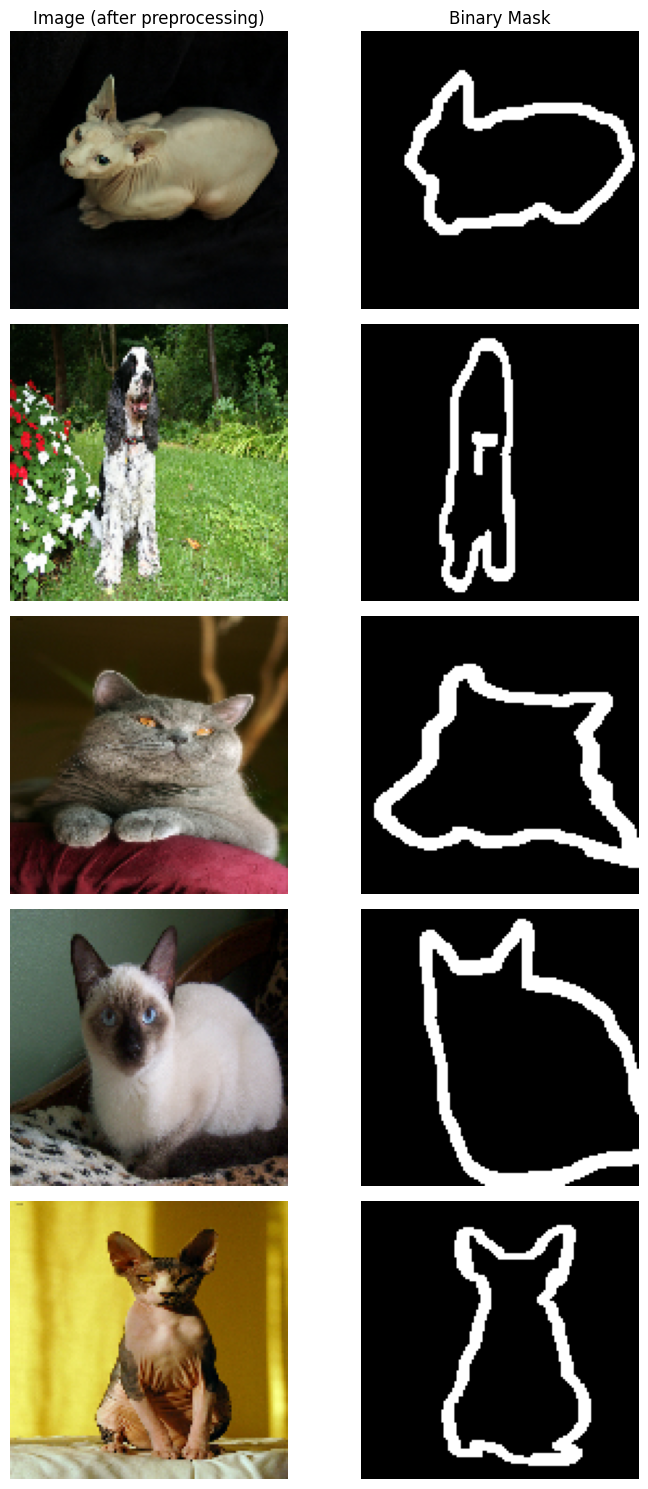

In [ ]:
def show_preprocessed_samples(dataset, num_samples=5):
    plt.figure(figsize=(8, num_samples * 3))

    for i, (image, mask) in enumerate(dataset.unbatch().take(num_samples)):
        ax1 = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image)
        plt.axis("off")
        if i == 0:
            ax1.set_title("Image (after preprocessing)")

        ax2 = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask[..., 0], cmap="gray")
        plt.axis("off")
        if i == 0:
            ax2.set_title("Binary Mask")

    plt.tight_layout()
    plt.show()


print("Визуализация препроцессированных train samples...")
sampled_dataset = prepare_dataset(ds_train.take(10), training=False)
show_preprocessed_samples(sampled_dataset)

# Построение U-net

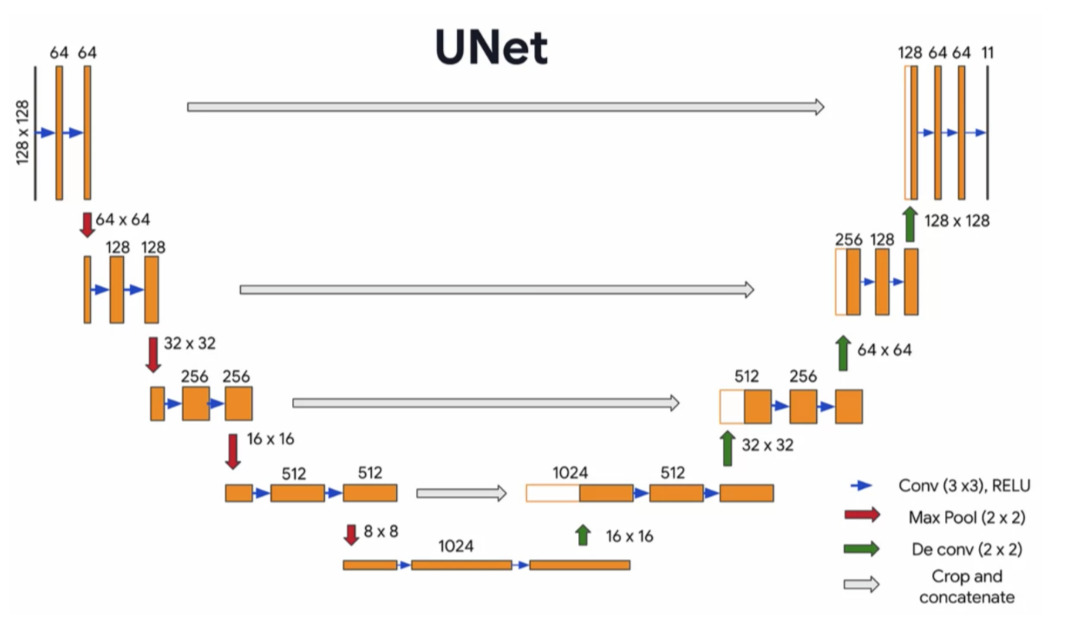

# Из за того что много слоёв в юнете повторяются разобъём их на блоки encoder decoder И conv с различными параметрами чтобы не повторяться

In [ ]:
def conv_block(x, filters):
  x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
  x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
  return x

def encoder_block(x, filters):
  c = conv_block(x, filters)
  p = layers.MaxPooling2D((2, 2))(c)
  return c, p

def decoder_block(x, skip, filters):
  us = layers.UpSampling2D((2, 2))(x)
  concat = layers.Concatenate()([us, skip])
  c = conv_block(concat, filters)
  return c

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
  inputs = layers.Input(shape=input_shape)

  c1, p1 = encoder_block(inputs, 64)
  c2, p2 = encoder_block(p1, 128)
  c3, p3 = encoder_block(p2, 256)
  c4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, c4, 512)
  d2 = decoder_block(d1, c3, 256)
  d3 = decoder_block(d2, c2, 128)
  d4 = decoder_block(d3, c1, 64)

  outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

  model = Model(inputs, outputs, name='U-Net')
  return model

# Построим модель

In [ ]:
model = build_unet()
#loss = sm.losses.DiceLoss()
#loss = sm.losses.BinaryFocalLoss()
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
loss = dice_loss + (1 * focal_loss)
model.compile(optimizer='adam',
loss=loss,
metrics=['accuracy',keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)])


model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 16, 16,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ up_sampling2d_4[

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

# Добавим коллбеки
1. Для сохранения чекопинтов
2. Для динамического изменения learning rate при стагнации

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

MODEL_DIR = '/content/drive/MyDrive/unet_pet_model'

os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, 'unet_pet_best_new.h5'),
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1
    )
]

# Начнём обучение

In [ ]:
history = model.fit(
train_dataset,
validation_data=val_dataset,
epochs=EPOCHS,
callbacks=callbacks,
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8378 - binary_io_u: 0.2644 - loss: 0.8944
Epoch 1: val_loss improved from inf to 0.79592, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 836ms/step - accuracy: 0.8380 - binary_io_u: 0.2653 - loss: 0.8939 - val_accuracy: 0.7969 - val_binary_io_u: 0.4499 - val_loss: 0.7959 - learning_rate: 0.0010
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8216 - binary_io_u: 0.4849 - loss: 0.7863
Epoch 2: val_loss improved from 0.79592 to 0.73610, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 628ms/step - accuracy: 0.8216 - binary_io_u: 0.4851 - loss: 0.7861 - val_accuracy: 0.8660 - val_binary_io_u: 0.5451 - val_loss: 0.7361 - learning_rate: 0.0010
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8565 - binary_io_u: 0.5391 - loss: 0.7258
Epoch 3: val_loss improved from 0.73610 to 0.71894, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 594ms/step - accuracy: 0.8565 - binary_io_u: 0.5392 - loss: 0.7257 - val_accuracy: 0.8301 - val_binary_io_u: 0.5187 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8670 - binary_io_u: 0.5626 - loss: 0.6843
Epoch 4: val_loss improved from 0.71894 to 0.65238, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 660ms/step - accuracy: 0.8671 - binary_io_u: 0.5626 - loss: 0.6842 - val_accuracy: 0.8868 - val_binary_io_u: 0.5971 - val_loss: 0.6524 - learning_rate: 0.0010
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8841 - binary_io_u: 0.5988 - loss: 0.6297
Epoch 5: val_loss improved from 0.65238 to 0.59111, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 643ms/step - accuracy: 0.8841 - binary_io_u: 0.5988 - loss: 0.6296 - val_accuracy: 0.8926 - val_binary_io_u: 0.6196 - val_loss: 0.5911 - learning_rate: 0.0010
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8912 - binary_io_u: 0.6169 - loss: 0.5963
Epoch 6: val_loss improved from 0.59111 to 0.57199, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 605ms/step - accuracy: 0.8912 - binary_io_u: 0.6169 - loss: 0.5962 - val_accuracy: 0.8911 - val_binary_io_u: 0.6250 - val_loss: 0.5720 - learning_rate: 0.0010
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8974 - binary_io_u: 0.6335 - loss: 0.5660
Epoch 7: val_loss improved from 0.57199 to 0.54993, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - accuracy: 0.8974 - binary_io_u: 0.6335 - loss: 0.5660 - val_accuracy: 0.9031 - val_binary_io_u: 0.6450 - val_loss: 0.5499 - learning_rate: 0.0010
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9042 - binary_io_u: 0.6504 - loss: 0.5373
Epoch 8: val_loss improved from 0.54993 to 0.54058, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 88s 597ms/step - accuracy: 0.9042 - binary_io_u: 0.6504 - loss: 0.5373 - val_accuracy: 0.9013 - val_binary_io_u: 0.6453 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 9/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9090 - binary_io_u: 0.6625 - loss: 0.5149
Epoch 9: val_loss did not improve from 0.54058
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 519ms/step - accuracy: 0.9090 - binary_io_u: 0.6625 - loss: 0.5149 - val_accuracy: 0.9007 - val_binary_io_u: 0.6439 - val_loss: 0.5443 - learning_rate: 0.0010
Epoch 10/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9118 - binary_io_u: 0.6711 - loss: 0.5008
Epoch 10: val_loss improved from 0.54058 to 0.51987, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 643ms/step - accuracy: 0.9118 - binary_io_u: 0.6711 - loss: 0.5008 - val_accuracy: 0.9083 - val_binary_io_u: 0.6621 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 11/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9145 - binary_io_u: 0.6807 - loss: 0.4826
Epoch 11: val_loss improved from 0.51987 to 0.50713, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 65s 682ms/step - accuracy: 0.9145 - binary_io_u: 0.6807 - loss: 0.4826 - val_accuracy: 0.9112 - val_binary_io_u: 0.6689 - val_loss: 0.5071 - learning_rate: 0.0010
Epoch 12/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9160 - binary_io_u: 0.6850 - loss: 0.4756
Epoch 12: val_loss improved from 0.50713 to 0.50420, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 692ms/step - accuracy: 0.9160 - binary_io_u: 0.6850 - loss: 0.4756 - val_accuracy: 0.9064 - val_binary_io_u: 0.6636 - val_loss: 0.5042 - learning_rate: 0.0010
Epoch 13/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9175 - binary_io_u: 0.6904 - loss: 0.4659
Epoch 13: val_loss improved from 0.50420 to 0.49403, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 65s 686ms/step - accuracy: 0.9175 - binary_io_u: 0.6904 - loss: 0.4659 - val_accuracy: 0.9115 - val_binary_io_u: 0.6733 - val_loss: 0.4940 - learning_rate: 0.0010
Epoch 14/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9213 - binary_io_u: 0.7008 - loss: 0.4485
Epoch 14: val_loss did not improve from 0.49403
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - accuracy: 0.9213 - binary_io_u: 0.7008 - loss: 0.4485 - val_accuracy: 0.9094 - val_binary_io_u: 0.6694 - val_loss: 0.5049 - learning_rate: 0.0010
Epoch 15/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9234 - binary_io_u: 0.7061 - loss: 0.4397
Epoch 15: val_loss improved from 0.49403 to 0.49217, saving model to /content/drive/MyDrive/unet_pet_model/unet_pet_best_new.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 607ms/step - accuracy: 0.9234 - binary_io_u: 0.7061 - loss: 0.4397 - val_accuracy: 0.9106 - val_binary_io_u: 0.6753 - val_loss: 0.4922 - learning_rate: 0.0010


# Проверка модели на тестовом датасете

In [ ]:
test_results = model.evaluate(test_dataset)
print(f"Test results: {dict(zip(model.metrics_names, test_results))}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 330ms/step - accuracy: 0.9142 - binary_io_u: 0.6938 - loss: 0.4605
Test results: {'loss': 0.45805123448371887, 'compile_metrics': 0.9147825837135315}


# Сохраняем модель

In [ ]:
model.save(os.path.join(MODEL_DIR, 'unet_pet_final_dualloss.h5'))

# Загружаем модель после того как коллаб отключился на интернете БГУ и перезагрузил окружение

In [ ]:
model = keras.saving.load_model(os.path.join(MODEL_DIR, 'unet_pet_final_dualloss.h5'), custom_objects=None, compile=True, safe_mode=True)

# Проверка инференса с выводом красивых собачек и котиков

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


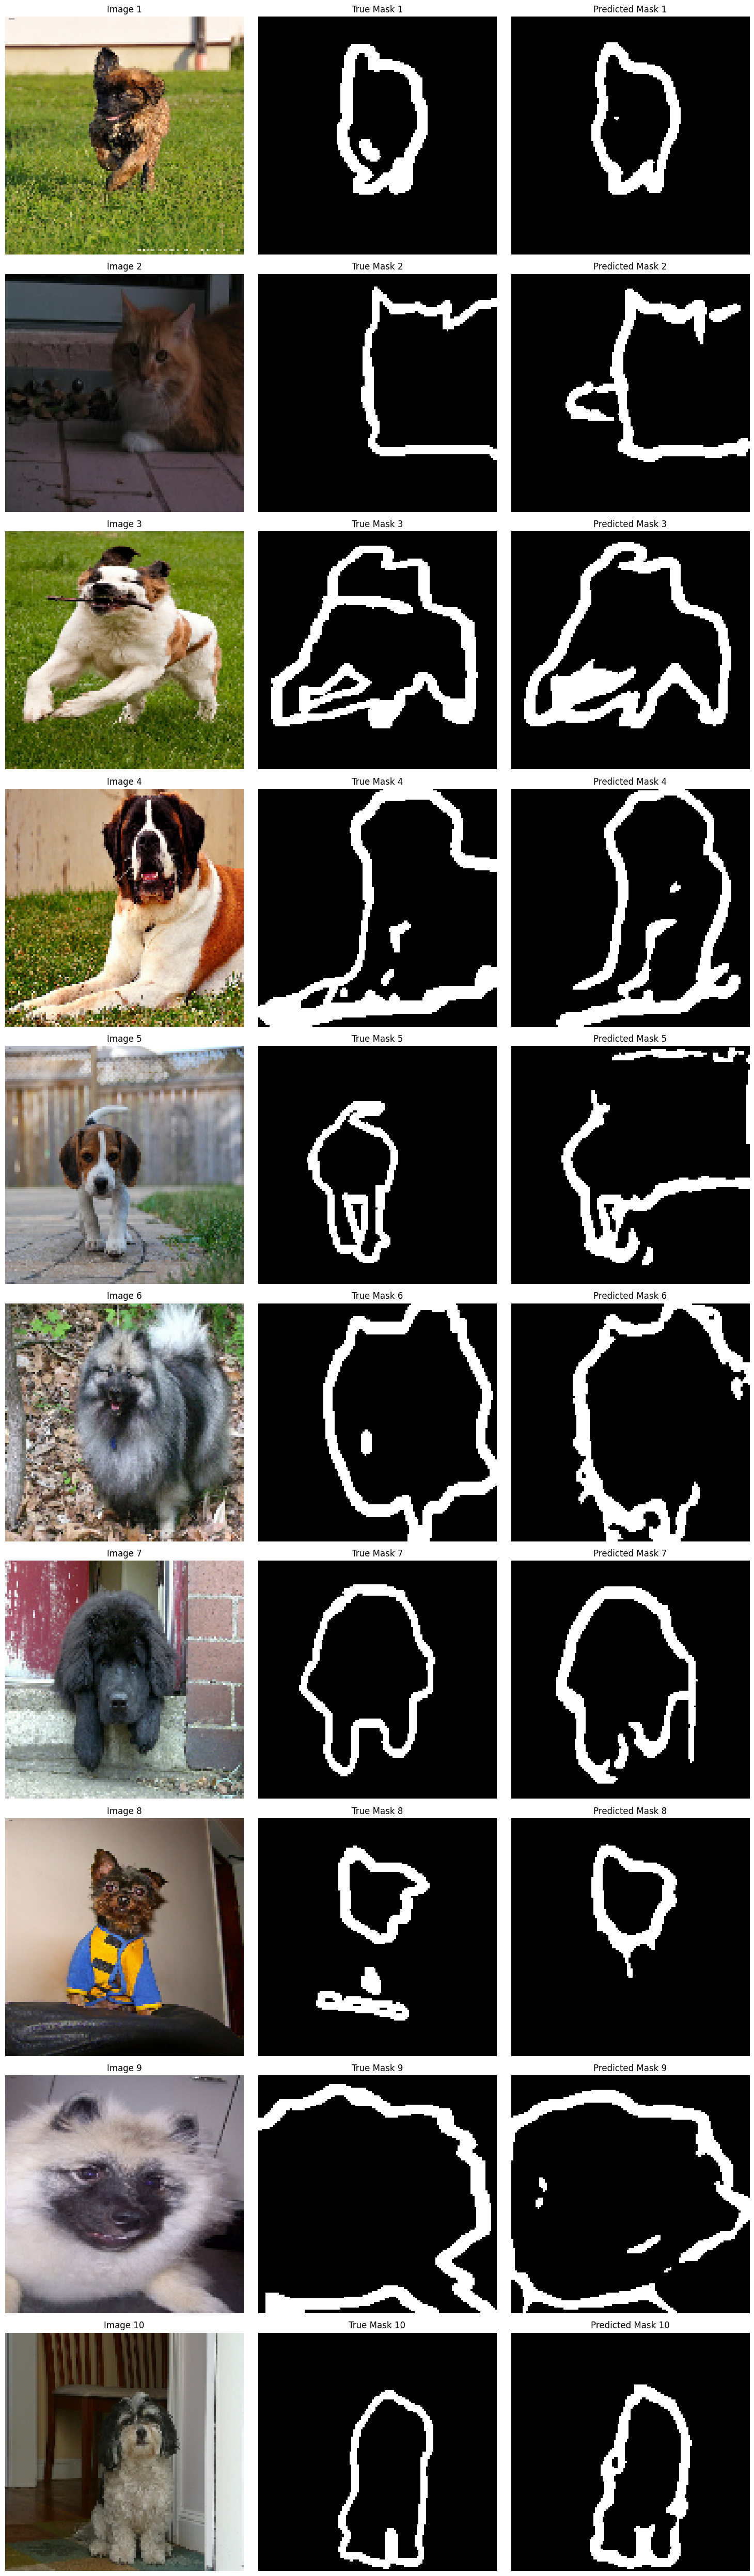

In [ ]:
def show_inference_examples(dataset, model, num_examples=3):
    for images, true_masks in dataset.take(1):
        predictions = model.predict(images[:num_examples])

        fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))

        for i in range(num_examples):
            # Исходное изображение
            axes[i, 0].imshow(images[i])
            axes[i, 0].set_title(f'Image {i+1}')
            axes[i, 0].axis('off')

            # Истинная маска
            axes[i, 1].imshow(true_masks[i, ..., 0], cmap='gray')
            axes[i, 1].set_title(f'True Mask {i+1}')
            axes[i, 1].axis('off')

            # Предсказанная маска (с порогом 0.5)
            pred_mask = (predictions[i, ..., 0] > 0.5).astype(np.float32)
            axes[i, 2].imshow(pred_mask, cmap='gray')
            axes[i, 2].set_title(f'Predicted Mask {i+1}')
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()
        break

show_inference_examples(test_dataset, model, 10)